### import statements 

In [2]:
import yfinance as yf 
import pandas as pd 
import numpy as np
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV


/Users/willbidle/Desktop/ilana_ml/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Matplotlib is building the font cache; this may take a moment.


### download data

In [31]:
ticker = yf.Ticker('^N225')
data = ticker.history(period = '2y')
display(data.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-11-14 00:00:00+09:00,28277.640625,28305.039062,27963.470703,27963.470703,85100000,0.0,0.0
2022-11-15 00:00:00+09:00,27940.259766,28038.630859,27903.269531,27990.169922,71200000,0.0,0.0
2022-11-16 00:00:00+09:00,28020.490234,28069.250000,27743.150391,28028.300781,73200000,0.0,0.0
2022-11-17 00:00:00+09:00,27952.210938,28029.619141,27910.009766,27930.570312,58900000,0.0,0.0
2022-11-18 00:00:00+09:00,28009.820312,28045.439453,27877.779297,27899.769531,64800000,0.0,0.0


### clean data

In [32]:
# drop rows with missing values 
data = data.dropna()
# check for and drop duplicate dates 
data = data[~data.index.duplicated(keep='first')]

### feature engineering

In [33]:
# window lengths for feature calculation 
short_window = 20  # short term ma window 
long_window = 50   # long term ma window 
vol_window = 20    # volatility window 

# moving averages 
data['sma_20'] = data['Close'].rolling(window=short_window).mean()
data['sma_50'] = data['Close'].rolling(window=long_window).mean()

# exponential moving average (EMA)
data['ema_20'] = data['Close'].ewm(span=short_window,adjust=False).mean()
data['ema_50'] = data['Close'].ewm(span=short_window,adjust=False).mean()

#relative strength index (rsi)
delta = data['Close'].diff(1) 
gain = delta.where(delta>0,0)
loss = -delta.where(delta<0,0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain/avg_loss

data['rsi'] = 100 - (100 / (1 +rs))

# volatility (rolling standard deviation of returns)
data['volatility'] = data['Close'].pct_change().rolling(window=vol_window).std()

# momentum (price difference over the period)
data['momentum'] = data['Close'] - data['Close'].shift(short_window)

# moving average convergence divergence (macd)
data['ema_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['ema_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['macd'] = data['ema_12'] - data['ema_26']

data['signal_line'] = data['macd'].ewm(span=9, adjust=False).mean()
data['macd_histogram'] = data['macd'] - data['signal_line']
data = data.dropna()
display(data.tail())


,Open,High,Low,Close,Volume,Dividends,Stock Splits,sma_20,sma_50,ema_20,ema_50,rsi,volatility,momentum,ema_12,ema_26,macd,signal_line,macd_histogram
Date,,,,,,,,,,,,,,,,,,,
2024-11-07 00:00:00+09:00,39745.230469,39884.011719,39020.218750,39381.410156,190000000,0.0,0.0,38901.779102,38211.528594,38756.994064,38756.994064,54.412138,0.012271,443.871094,38860.938570,38675.031304,185.907266,169.430036,16.477230
2024-11-08 00:00:00+09:00,39783.449219,39818.410156,39377.871094,39500.371094,159300000,0.0,0.0,38912.899609,38239.331641,38827.791877,38827.791877,54.822500,0.012138,222.410156,38959.312804,38736.167585,223.145220,180.173073,42.972147
2024-11-11 00:00:00+09:00,39417.210938,39598.738281,39315.609375,39533.320312,122700000,0.0,0.0,38920.521094,38264.225625,38894.985061,38894.985061,55.375531,0.012127,152.429688,39047.621652,38795.215935,252.405717,194.619602,57.786115
2024-11-12 00:00:00+09:00,39642.781250,39866.718750,39137.890625,39376.089844,163000000,0.0,0.0,38909.035547,38284.312187,38940.804564,38940.804564,59.646135,0.012092,-229.710938,39098.155220,38838.243632,259.911588,207.677999,52.233589
2024-11-13 00:00:00+09:00,39317.148438,39377.238281,38600.261719,38721.660156,0,0.0,0.0,38849.591016,38291.494766,38919.933668,38919.933668,55.770084,0.012470,-1188.890625,39040.232902,38829.607819,210.625083,208.267416,2.357668


### plot 

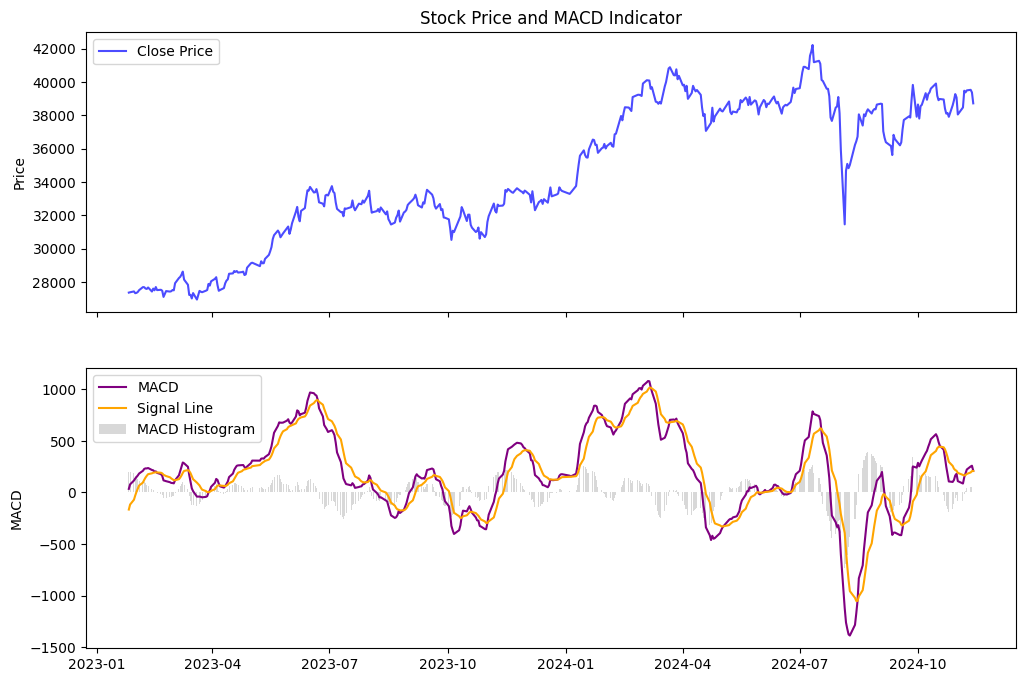

In [34]:
# Set up the figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)
# Plot the Closing Price
ax1.plot(data['Close'], label='Close Price', color='blue', alpha=0.7)
ax1.set_title("Stock Price and MACD Indicator")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")
# Plot the MACD and Signal Line
ax2.plot(data['macd'], label='MACD', color='purple', linewidth=1.5)
ax2.plot(data['signal_line'], label='Signal Line', color='orange', linewidth=1.5)
# Plot the MACD Histogram as a bar plot
ax2.bar(data.index, data['macd_histogram'], label='MACD Histogram', color='grey', alpha=0.3)
# Set labels and title for the MACD plot
ax2.set_ylabel("MACD")
ax2.legend(loc="upper left")
# Display the plot
plt.show()

### define long - short signals

In [35]:
data['position'] = np.nan
# define long position(1) when macd crosses above signal line 
data.loc[data['macd'] > data['signal_line'], 'position'] = 1 
# define short position(-1) when macd crosses below signal line 
data.loc[data['macd'] < data['signal_line'], 'position'] = -1 

data['position'] = data['position'].ffill()
display(data.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,sma_20,sma_50,ema_20,ema_50,rsi,volatility,momentum,ema_12,ema_26,macd,signal_line,macd_histogram,position
Date,,,,,,,,,,,,,,,,,,,,
2024-11-07 00:00:00+09:00,39745.230469,39884.011719,39020.218750,39381.410156,190000000,0.0,0.0,38901.779102,38211.528594,38756.994064,38756.994064,54.412138,0.012271,443.871094,38860.938570,38675.031304,185.907266,169.430036,16.477230,1.0
2024-11-08 00:00:00+09:00,39783.449219,39818.410156,39377.871094,39500.371094,159300000,0.0,0.0,38912.899609,38239.331641,38827.791877,38827.791877,54.822500,0.012138,222.410156,38959.312804,38736.167585,223.145220,180.173073,42.972147,1.0
2024-11-11 00:00:00+09:00,39417.210938,39598.738281,39315.609375,39533.320312,122700000,0.0,0.0,38920.521094,38264.225625,38894.985061,38894.985061,55.375531,0.012127,152.429688,39047.621652,38795.215935,252.405717,194.619602,57.786115,1.0
2024-11-12 00:00:00+09:00,39642.781250,39866.718750,39137.890625,39376.089844,163000000,0.0,0.0,38909.035547,38284.312187,38940.804564,38940.804564,59.646135,0.012092,-229.710938,39098.155220,38838.243632,259.911588,207.677999,52.233589,1.0
2024-11-13 00:00:00+09:00,39317.148438,39377.238281,38600.261719,38721.660156,0,0.0,0.0,38849.591016,38291.494766,38919.933668,38919.933668,55.770084,0.012470,-1188.890625,39040.232902,38829.607819,210.625083,208.267416,2.357668,1.0


### build and train random forest classifier

In [38]:
# define features and target
features = ['macd','signal_line','rsi','sma_20','ema_20','ema_50']
target = 'position'

# prep features and target var 
x = data[features]
y = data[target]

# drop rows with missiing values 
x = x.dropna()
y = y[x.index] # make sure target var matches the features 

# split the data 
x_train, x_test, y_train,y_test = train_test_split(x,y, test_size=0.2,shuffle=True)
# print(len(x_train),len(x_test))

# initialize random forest classifier 
rf_model = RandomForestClassifier(max_depth = 10, min_samples_leaf=5, n_estimators=100, random_state=42,oob_score=True)
# train the model 
rf_model.fit(x_train,y_train)

# make predictions on the test set 
y_pred = rf_model.predict(x_test)
# evaluate the model 
accuracy = accuracy_score(y_test,y_pred)
print('accuracy: ',accuracy)
print('classification report: ')
print(classification_report(y_test,y_pred))
print('confusion matrix: ')
print(confusion_matrix(y_test,y_pred))

accuracy:  0.9438202247191011
classification report: 
              precision    recall  f1-score   support

        -1.0       0.96      0.87      0.92        31
         1.0       0.93      0.98      0.96        58

    accuracy                           0.94        89
   macro avg       0.95      0.93      0.94        89
weighted avg       0.94      0.94      0.94        89

confusion matrix: 
[[27  4]
 [ 1 57]]


In [39]:
# check oob score, becuase random forest classfiier immediately creates this as a validation set 
print(rf_model.oob_score_)

0.884180790960452


### plot roc and calculate auc

In [47]:
# predict probabilities for the positive class 
y_probs = rf_model.predict_proba(x_test)[:,1]
# calculate roc curve 
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
# calculate auc 
roc_auc = roc_auc_score(y_test, y_probs)

In [53]:
print(y_probs[:5])
print(y_test[:5].to_numpy())

[0.99333333 0.87804064 0.74055805 0.09036941 0.54345496]
[ 1.  1.  1. -1.  1.]


ValueError: x and y must have same first dimension, but have shapes (89,) and (16,)

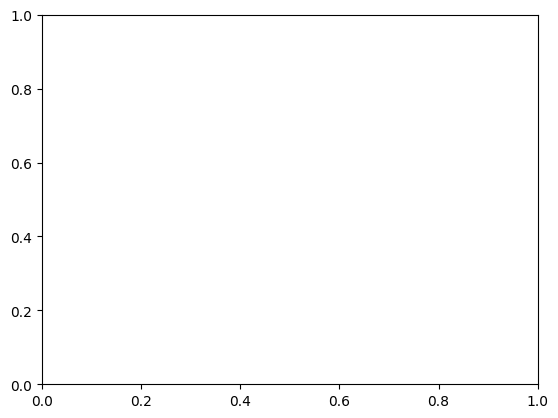

In [54]:
plt.plot(y_probs, fpr)
plt.show()

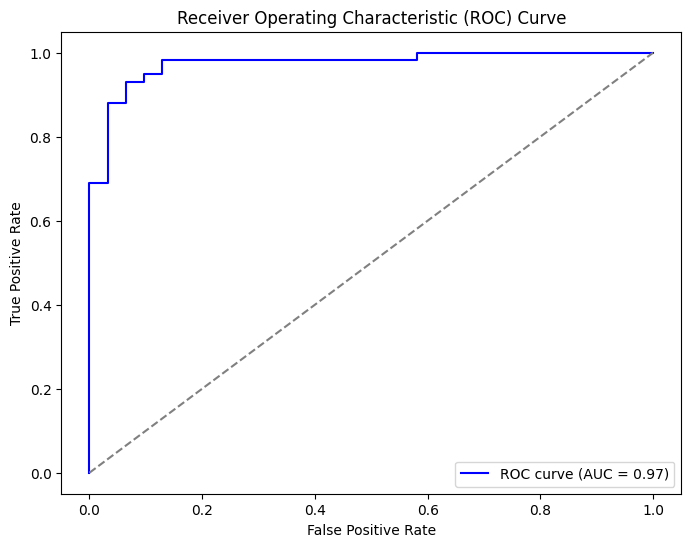

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for random performance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### hyperparameter tuning 

In [42]:
%%time
# set the parameters that we want to search 
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
CPU times: user 2.18 s, sys: 331 ms, total: 2.51 s
Wall time: 29.9 s


/Users/willbidle/Desktop/ilana_ml/myenv/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                              oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

### plot feature importance

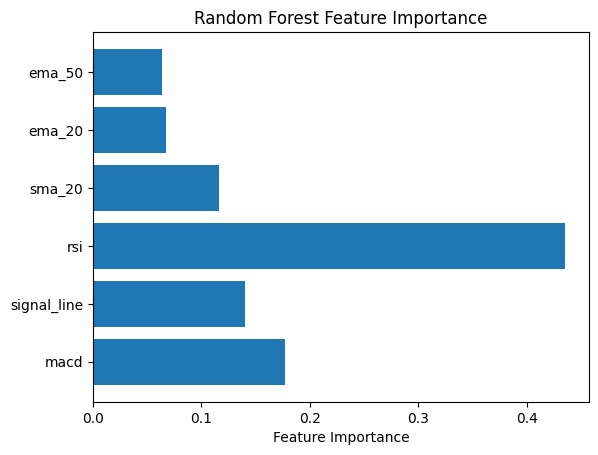

'decision tree.pdf'

In [43]:
feature_importance = rf_model.feature_importances_
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

# visualize one of the classifiers 
dot_data = export_graphviz(rf_model.estimators_[0], 
                             out_file=None, 
                             feature_names = x.columns, 
                             class_names=['-1','1'],
                             filled=True,
                             rounded=True,
                             special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision tree",format='png',cleanup=True)
graph.view()

### generate predictions

In [44]:
data['predicted_position'] = rf_model.predict(x)
final = data[['position', 'predicted_position']]
display(final)

,position,predicted_position
Date,,
2023-01-26 00:00:00+09:00,1.0,1.0
2023-01-27 00:00:00+09:00,1.0,1.0
2023-01-30 00:00:00+09:00,1.0,1.0
2023-01-31 00:00:00+09:00,1.0,1.0
2023-02-01 00:00:00+09:00,1.0,1.0
...,...,...
2024-11-07 00:00:00+09:00,1.0,1.0
2024-11-08 00:00:00+09:00,1.0,1.0
2024-11-11 00:00:00+09:00,1.0,1.0


In [46]:
display(data.loc[data['position'] != data['predicted_position']])

,Open,High,Low,Close,Volume,Dividends,Stock Splits,sma_20,sma_50,ema_20,...,rsi,volatility,momentum,ema_12,ema_26,macd,signal_line,macd_histogram,position,predicted_position
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-17 00:00:00+09:00,27484.599609,27608.589844,27466.609375,27513.130859,68800000,0.0,0.0,27467.344141,27015.462773,27385.025950,...,52.544581,0.005926,959.601562,27507.998171,27317.894436,190.103735,194.787100,-4.683365,-1.0,1.0
2023-02-20 00:00:00+09:00,27497.130859,27531.939453,27426.480469,27531.939453,62500000,0.0,0.0,27498.639160,27012.373555,27399.017712,...,56.923727,0.005276,625.900391,27511.681445,27333.749623,177.931823,191.416045,-13.484222,-1.0,1.0
2023-03-30 00:00:00+09:00,27827.890625,27876.380859,27630.550781,27782.929688,82000000,0.0,0.0,27684.621777,27494.761758,27570.491005,...,38.133818,0.011013,266.400391,27576.015957,27556.687718,19.328239,6.294103,13.034136,1.0,-1.0
2023-04-10 00:00:00+09:00,27658.519531,27737.490234,27597.179688,27633.660156,48000000,0.0,0.0,27573.137891,27619.602656,27687.528395,...,62.826132,0.010656,-510.310547,27711.332896,27663.756052,47.576844,63.484004,-15.907160,-1.0,1.0
2023-04-11 00:00:00+09:00,27895.900391,28068.390625,27854.820312,27923.369141,64800000,0.0,0.0,27577.658301,27630.418828,27709.989418,...,59.318753,0.010660,90.408203,27743.953857,27682.986651,60.967206,62.980644,-2.013439,-1.0,1.0
2023-09-21 00:00:00+09:00,32865.558594,32939.890625,32550.650391,32571.029297,107900000,0.0,0.0,32713.799609,32494.285820,32757.701448,...,49.321868,0.010014,560.769531,32873.815310,32694.564731,179.250579,169.147336,10.103243,1.0,-1.0
2023-10-16 00:00:00+09:00,31983.039062,31999.789062,31564.310547,31659.029297,84500000,0.0,0.0,32080.802930,32235.168242,31981.839379,...,40.252909,0.013162,-1509.072266,31870.004290,32053.219943,-183.215653,-221.515003,38.299350,1.0,-1.0
2023-10-25 00:00:00+09:00,31302.509766,31466.919922,31195.580078,31269.919922,78700000,0.0,0.0,31597.691309,32122.819609,31678.628901,...,57.970678,0.013278,-1045.130859,31506.207344,31778.585800,-272.378456,-225.425469,-46.952987,-1.0,1.0
2023-11-01 00:00:00+09:00,31311.220703,31601.650391,31301.509766,31601.650391,130100000,0.0,0.0,31380.244824,32044.875977,31406.949473,...,40.677205,0.014841,363.710938,31228.198012,31523.362572,-295.164560,-295.774575,0.610016,1.0,-1.0
